<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v4)
This notebook is the first step towards building up to a real SLAM model.
It focuses on proving out the model architecture, without going into too much w.r.t. proper data generation.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout 63bcc74
!cd repo && git pull

import sys
sys.path.append('repo')

import lds
import map_from_lds_train_data
import slam
import unet
from importlib import reload
reload(lds)
reload(map_from_lds_train_data)
reload(slam)
reload(unet)

HEAD is now at 5edc743 Diabolically simple model still not working at all
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 174.42 KiB | 549.00 KiB/s, done.
From https://github.com/malcolmlett/robovac
   5edc743..eccdedc  main       -> origin/main
Updating 5edc743..eccdedc
Fast-forward
 Experiment_SLAM_1.ipynb | 435 ++++++++++++++++++++++++++++++++++++++++++++++++++++----------------
 1 file changed, 335 insertions(+), 100 deletions(-)


<module 'unet' from '/content/repo/unet.py'>

In [2]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
from timeit import default_timer as timer

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Add


## Helper functions


## Load Floorplan

In [3]:
def one_hot_encode_floorplan(image):
    """
    Converts an RGB floorplan image into a one-hot encoded tensor of the same form
    used as input and output maps in the SLAM model.

    Ordered channels are:
    - floor (white in the RGB image)
    - obstruction (black in the RGB image)
    - unknown (grey in the RGB image)

    Args:
      image: (H,W,3) RGB floorplan image

    Returns:
      (H,W,C) one-hot encoded tensor of the floorplan image
    """
    # sanity check
    if not np.array_equal(np.unique(image), np.array([0, 192, 255])):
      raise ValueError(f"Encountered unexpected values in image, expected [0, 192, 255], got: {np.unique(image)}")

    # get each channel
    floor_mask = tf.reduce_all(tf.equal(image, [255, 255, 255]), axis=-1)
    obstruction_mask = tf.reduce_all(tf.equal(image, [0, 0, 0]), axis=-1)
    unknown_mask = tf.reduce_all(tf.equal(image, [192, 192, 192]), axis=-1)

    # Stack the masks along the last dimension to create a one-hot encoded tensor
    one_hot_image = tf.stack([floor_mask, obstruction_mask, unknown_mask], axis=-1)

    return tf.cast(one_hot_image, tf.float32)

In [4]:
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

floorplan = one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

PIXEL_SIZE = 4.741
MAX_DISTANCE = 350

RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


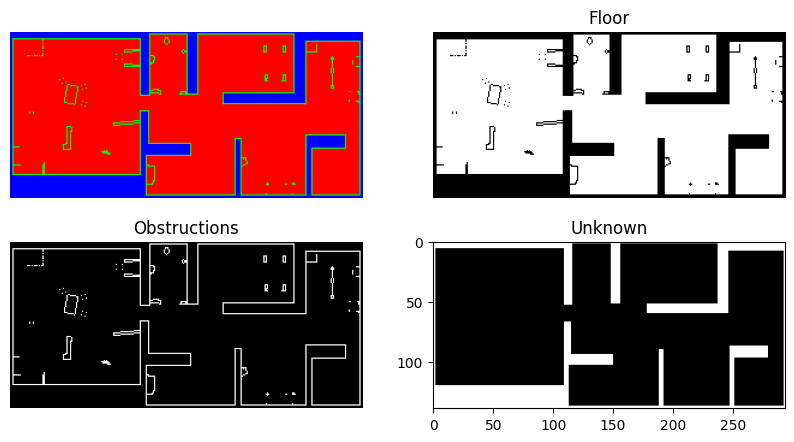

In [5]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(floorplan)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Floor')
plt.imshow(floorplan[:,:,0], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Obstructions')
plt.imshow(floorplan[:,:,1], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Unknown')
plt.imshow(floorplan[:,:,2], cmap='gray')
#plt.axis('off')

## Training data
Here we're going to need to generate new training data. The old training data is in the wrong data structure, uses the wrong encoding for our needs, and used a simple floorplan.

In [6]:
def save_dataset(dataset, file):
  # Iterate through the dataset and collect the data
  input_maps = []
  lds_maps = []
  ground_truth_maps = []
  adlos = []
  for (inputs, outputs) in dataset:
      input_maps.append(inputs[0].numpy())
      lds_maps.append(inputs[1].numpy())
      ground_truth_maps.append(outputs[0].numpy())
      adlos.append(outputs[1].numpy())

  print(f"Saving:")
  print(f"  input_maps:        {np.shape(input_maps)}")
  print(f"  lds_maps:          {np.shape(lds_maps)}")
  print(f"  ground_truth_maps: {np.shape(ground_truth_maps)}")
  print(f"  adlos:             {np.shape(adlos)}")

  np.savez_compressed(file,
                      input_maps=np.array(input_maps),
                      ld_maps=np.array(lds_maps),
                      ground_truth_maps=np.array(ground_truth_maps),
                      adlos=np.array(adlos))
  print(f"Dataset saved to {file}")

def load_dataset(file):
  data = np.load(file)
  input_maps = data['input_maps']
  lds_maps = data['ld_maps']
  ground_truth_maps = data['ground_truth_maps']
  adlos = data['adlos']

  print(f"Loaded:")
  print(f"  input_maps:        {np.shape(input_maps)}")
  print(f"  lds_maps:          {np.shape(lds_maps)}")
  print(f"  ground_truth_maps: {np.shape(ground_truth_maps)}")
  print(f"  adlos:             {np.shape(adlos)}")

  dataset = tf.data.Dataset.from_tensor_slices((
      (input_maps, lds_maps),
      (ground_truth_maps, adlos)
  ))
  print(f"Dataset loaded from {file}")
  return dataset

def validate_dataset(dataset):
  # Sanity check generated data
  def assert_in_range(name, tensor, allowed_min, allowed_max):
    if np.min(tensor) < allowed_min or np.max(tensor) > allowed_max:
      raise ValueError(f"{name} has values outside of desired range, found: {np.min(tensor)}-{np.max(tensor)}")

  count = 0
  for (map_window, lds_map), (ground_truth_map, adlo) in dataset:
    assert_in_range("map_window", map_window, 0.0, 1.0)
    assert_in_range("lds_map", map_window, 0.0, 1.0)
    assert_in_range("ground_truth_map", map_window, 0.0, 1.0)
    assert_in_range("accept", adlo[0], 0.0, 1.0)
    assert_in_range("loc-x", adlo[1], -0.5, 0.5)
    assert_in_range("loc-y", adlo[2], -0.5, 0.5)
    assert_in_range("orientation", adlo[3], -1.0, 1.0)
    count += 1
  print(f"Dataset tests passed ({count} entries verified)")

def show_dataset(dataset, num=5):
  def add_to_plot(map_window, lds_map, ground_truth_map, adlo):
    print(f"map_window:       {map_window.shape}")
    print(f"lds_map:          {lds_map.shape}")
    print(f"ground_truth_map: {ground_truth_map.shape}")
    print(f"adlo:             {adlo}")

    range = np.array([map_window.shape[1], map_window.shape[0]])
    centre = range / 2
    error_loc = centre + adlo[1:3]*range
    angle_loc = error_loc + np.array([np.cos(adlo[3]*np.pi), np.sin(adlo[3]*np.pi)])*50

    plt.figure(figsize=(10,2))
    plt.subplot(1, 3, 1)
    plt.title('Map')
    plt.imshow(map_window)
    plt.axis('off')
    plt.plot([error_loc[0], angle_loc[0]], [error_loc[1], angle_loc[1]], c='m')
    plt.scatter(centre[0], centre[1], c='k', s=50)
    plt.scatter(error_loc[0], error_loc[1], c='m', s=50)

    plt.subplot(1, 3, 2)
    plt.title('LDS')
    plt.imshow(lds_map, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Ground Truth')
    plt.imshow(ground_truth_map, cmap='gray')
    plt.axis('off')
    plt.show()

  for (map_window, lds_map), (ground_truth_map, adlo) in train_data.take(num):
    add_to_plot(map_window, lds_map, ground_truth_map, adlo)

In [8]:
# If generated data is available then load that to save time:
#train_data = load_dataset('experimental-slam-training-data1.npz')
train_data = load_dataset('experimental-slam-training-data1-type1only.npz')
validate_dataset(train_data)

Loaded:
  input_maps:        (1000, 149, 149, 3)
  lds_maps:          (1000, 149, 149)
  ground_truth_maps: (1000, 149, 149, 3)
  adlos:             (1000, 4)
Dataset loaded from experimental-slam-training-data1-type1only.npz
Dataset tests passed (1000 entries verified)


map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.3]


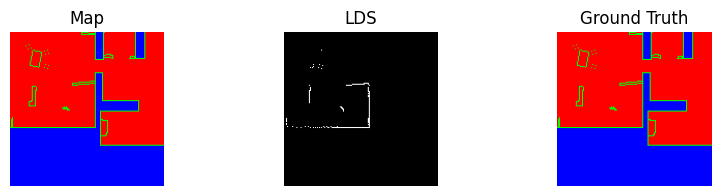

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.3]


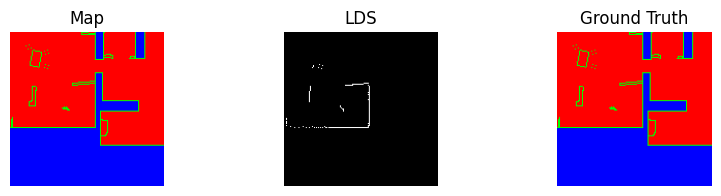

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.3]


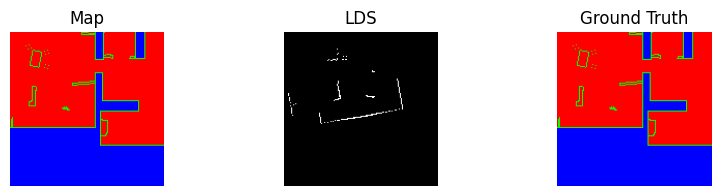

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.3]


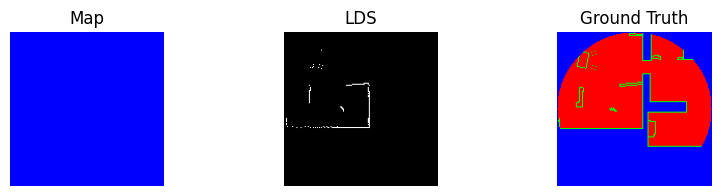

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.3]


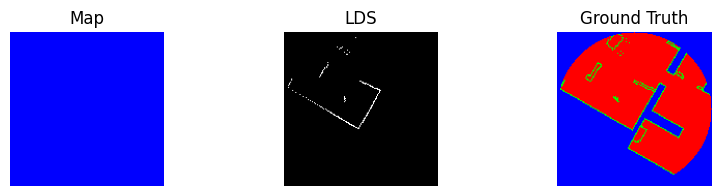

In [10]:
def generate_training_data_sample(semantic_map, location, orientation, map_known, location_error, orientation_error, **kwargs):
    """
    Simulates information that the agent might have and should infer given the agent's true location/orientation
    and the error in its estimate of that location/orientation.

    Can be used to simulate when the agent is moving around an existing known map, by setting map_known=True
    and supplying reasonable location and orientation errors.
    This causes the LDS data to be aligned to the map, depending only on the location and orientation error.
    In this situation, the main orientation parameter only selects where the LDS scan is started from,
    and introduces slight variations in the LDS data collected due to its 1-degree resolution.

    Can be used to simulate when searching the map for the agent's location, by setting orientation_error=np.inf.
    This causes the LDS data to be freely rotated relative to the map.

    Can be used to simulate when the agent has first started in a new area by setting map_known=False,
    in which case the input map is blank and the ground_truth map is rotated to the orientation of the agent.

    :param semantic_map: (H,W,C) = one-hot encoded floorplan
    :param location: (float, float) = (x,y) ground-truth location of agent
    :param orientation: (float) = radians ground-truth angle of orientation of agent
    :param map_known: bool, whether to simulate the agent knowing this section of map or having a blank input map
    :param location_error: None or float tuple, (delta x, deltay).
       Simulates an error on the agent's estimated location. Causes the LDS map to be offset relative to the map,
       in the opposite direction of the error.
       None for no error.
       Generally this should be None if map_known=False.
    :param orientation_error: None or float, radians.
       Simulates an error on the agent's estimated orientation. Causes the LDS map to be rotated relative to the map,
       in the opposite direction of the error.
       None for no error.
       Inf or NaN for unknown orientation, causing the LDS map to be oriented with the true starting angle shifted to zero degrees.
       Generally this should be None if map_known=False.
    :param kwargs:
    :return:
      (input_map, input_lds_image, ground_truth_output_map, ground_truth_output_adlo)
    """
    # config
    max_distance = kwargs.get('max_distance', 100)
    pixel_size = kwargs.get('pixel_size', 1.0)
    #nothing_value = kwargs.get('nothing_value', np.array([1,0,0], dtype=semantic_map.dtype))
    #occupied_value = kwargs.get('occupied_value', np.array([0,1,0], dtype=semantic_map.dtype))
    unknown_value = kwargs.get('unknown_value', np.array([0,0,1], dtype=semantic_map.dtype))
    location_error = np.array(location_error) if location_error is not None else np.array([0.0, 0.0])
    orientation_error = orientation_error if orientation_error is not None else 0.0
    window_size_px = np.ceil(max_distance / pixel_size).astype(int) * 2 + 1
    window_size_px = np.array([window_size_px, window_size_px])
    n_channels = semantic_map.shape[-1]

    #print(f"location: {location} + {location_error}, orientation: {orientation} + {orientation_error}, map_known: {map_known}, pixel_size: {pixel_size}, window_size: {window_size_px}")

    # take LDS sample
    lds_orientation = (orientation + orientation_error) if np.isfinite(orientation_error) else orientation
    ranges = lds.lds_sample(semantic_map[:,:,1], location + location_error, lds_orientation, max_distance=max_distance, pixel_size=pixel_size)
    if (np.nanmax(ranges) < pixel_size) or ranges[~np.isnan(ranges)].size == 0:
        return None, None, None, None

    # generate input map
    # (aligned to map pixels, and zero rotation)
    location_fpx = location / pixel_size  # sub-pixel resolution ("float pixels")
    location_px = np.round(location_fpx).astype(int)
    location_alignment_offset_fpx = location_fpx - location_px  # true centre relative to window centre
    #print(f"window_size: {window_size_px}, location: {location_px} + {location_alignment_offset_fpx} = {location_fpx}")
    if map_known:
      map_window = map_from_lds_train_data.rotated_crop(semantic_map, location_px, 0.0, size=window_size_px, mask='none', pad_value=unknown_value)
    else:
      # all unknown
      map_window = np.tile(unknown_value, (window_size_px[0], window_size_px[1], 1))
    #print(f"map_window: {map_window.shape}")

    # generate ground-truth map
    # (map_known:  aligned to map pixels and zero rotation)
    # (!map_known: aligned to exact centre of window and agent's ground truth orientation)
    if map_known:
      ground_truth_map = map_from_lds_train_data.rotated_crop(semantic_map, location_px, 0.0, size=window_size_px, mask='none', pad_value=unknown_value)
    else:
      ground_truth_map = map_from_lds_train_data.rotated_crop(semantic_map, location_fpx, orientation, size=window_size_px, mask='inner-circle', pad_value=unknown_value)
    #print(f"ground_truth_map: {ground_truth_map.shape}")

    # generate LDS semantic map
    # (oriented according to agent's believed orientation, which omits the orientation_error,
    #  and is 0.0 if completely unknown)
    believed_orientation = orientation if map_known and np.isfinite(orientation_error) else 0.0
    lds_map = lds_to_occupancy_map(ranges, start_angle=believed_orientation, size_px=window_size_px, centre_px=location_alignment_offset_fpx, pixel_size=pixel_size)

    return map_window, lds_map, ground_truth_map, location_alignment_offset_fpx

def lds_to_occupancy_map(ranges, start_angle, size_px, **kwargs):
    """
    :param ranges: array (n,) - range values may contain nans, which are dropped
    :param start_angle: angle of first range (radians)
    :param centre_px: array (2,) = float, [x,y] - centre point for ranges
    :param size_px: int/float or tuple (h, w) = size of output map in pixels
    :param kwargs

    Keyword args:
      pixel_size:
      centre_px: tuple, float (x,y), relative to map centre (unit: pixels)
        Usually centres LDS data exactly on centre of generated map (to sub-pixel resolution).
        Use this to shift by some amount.
      encoding: one of 'nn', 'antialiased', 'nn+offset':
        nn: nearest neighbour
        (TODO) antialised: blurs into adjacent pixels for implied sub-pixel resolution
        (TODO) nn+offset: picks single NN pixel, but on second and third channels adds
          x and y offset (-0.5 .. +0.5) in sub-pixel resolution

    :return: array (h,w) of floats in range [0,1]
    """

    # config
    pixel_size = kwargs.get('pixel_size', 1.0)
    centre_px = kwargs.get('centre_px', (0.0, 0.0))
    size_px = np.array(size_px) if len(size_px) == 2 else np.array([size_px, size_px])

    map_centre_fpx = np.array((size_px-1) / 2) + np.array(centre_px)

    #print(f"pixel_size: {pixel_size}, centre_px: {centre_px}, map_centre_fpx: {map_centre_fpx}")

    lds_points = lds.lds_to_2d(ranges, (0, 0), start_angle)
    lds_points_px = np.round(lds_points/pixel_size + map_centre_fpx).astype(int)
    lds_map = np.full(size_px, 0.0, dtype=np.float32)
    lds_map[lds_points_px[:,1], lds_points_px[:,0]] = 1.0

    return lds_map

def display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset):
  print(f"map_window:       {map_window.shape}")
  print(f"lds_map:          {lds_map.shape}")
  print(f"ground_truth_map: {ground_truth_map.shape}")
  print(f"centre offset:    {centre_offset}")

  plt.figure(figsize=(10, 2))

  plt.subplot(1, 3, 1)
  plt.title('Map')
  plt.imshow(map_window)
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title('LDS')
  plt.imshow(lds_map, cmap='gray')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title('Ground Truth')
  plt.imshow(ground_truth_map, cmap='gray')
  plt.axis('off')
  plt.show()


reload(map_from_lds_train_data)
pixel_size = 4.741
location = np.array([100.2, 100.7]) * pixel_size
window_size = np.ceil(350 / pixel_size).astype(int) * 2 + 1

# perfect example
map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, 0.0, True, (0,0), 0, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

# different orientation
map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, np.deg2rad(30.5), True, (0,0), 0, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

# estimation error
map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, 0.0, True, (-150.0, +50.0), np.deg2rad(-10.0), pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

# map unknown - facing one way
map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, 0.0, False, None, None, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

# map unknown - facing a different way
map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, np.deg2rad(30.0), False, None, None, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

In [11]:
def generate_training_data(semantic_map, num_samples, **kwargs):
    tot_sample_types = 4
    pixel_size = kwargs.get('pixel_size', PIXEL_SIZE)
    max_distance = kwargs.get('max_distance', MAX_DISTANCE)
    sample_types = np.array(kwargs.get('sample_types', range(tot_sample_types)))
    print(f"Generating {num_samples} samples of training data")
    print(f"Pixel size: {pixel_size}")
    print(f"Max distance: {max_distance}")
    print(f"Sample types: {sample_types}")

    # identify ranges
    # - size of full map (W, H), physical units
    # - size of window (W, H), physical units
    full_map_loc_range = np.array([semantic_map.shape[1], semantic_map.shape[0]]) * pixel_size
    window_size = (np.ceil(max_distance / pixel_size).astype(int) * 2 + 1) * pixel_size
    window_range = np.array([window_size, window_size])

    input_maps = []
    lds_maps = []
    ground_truth_maps = []
    adlos = []
    attempts = 0
    for _ in tqdm.tqdm(range(num_samples)):
        # keep trying until we generate one sample
        while True:
            attempts += 1
            sample_type = np.random.choice(sample_types)
            location = np.random.uniform((0,0), full_map_loc_range)
            angle = np.random.uniform(-np.pi, np.pi)
            accept = True
            loc_error = (0.0, 0.0)
            angle_error = 0.0
            #print(f"sample_type: {sample_type}, loc_range: {loc_range}, location: {location}, angle: {angle}")

            if sample_type == 0:
              # New map, unknown location and orientation, loc/angle error disregarded
              map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(
                  floorplan, location, angle, False, None, None, pixel_size=pixel_size, max_distance=max_distance)

            elif sample_type == 1:
              # Known map, known location/angle with some small uniform estimation error
              loc_error = np.random.normal((0,0), window_range/2 * 0.1)  # normal about centre, std.dev = 10% of range
              angle_error = np.random.uniform(0, np.pi * 0.1)            # normal about zero, std.dev = 10% of 180 degrees
              loc_error = np.clip(loc_error, -window_range/2, +window_range/2)
              angle_error = np.clip(angle_error, -np.pi, +np.pi)
              map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(
                  floorplan, location, angle, True, loc_error, angle_error, pixel_size=pixel_size, max_distance=max_distance)

            elif sample_type == 2:
              # Known map, location unknown and searching, with LDS data partially on this map window.
              # Location of map window independent of LDS data so simulate using uniform location and
              # orientation error within bounds of the window
              loc_error = np.random.uniform(-window_range/2, +window_range/2)  # uniform either side of zero, anywhere within window
              angle_error = np.random.uniform(-np.pi, np.pi)                   # uniform anywhere within 360-degree range
              map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(
                  floorplan, location, angle, True, loc_error, angle_error, pixel_size=pixel_size, max_distance=max_distance)

            elif sample_type == 3:
              # Known map, location unknown and searching, with LDS not on this map window.
              # Generate LDS from completely independent random location/orientation within full map
              # TODO find a more efficient way to ensure that the ground-truth only includes what the LDS data can see.
              # (TODO use some smarts to pick a location that is a full max_distance diameter away but still on the floorplan)
              lds_loc = np.random.uniform((0,0), full_map_loc_range)     # uniform anywhere within full map
              lds_angle = np.random.uniform(-np.pi, np.pi)               # uniform anywhere within 360-degree range
              loc_error = lds_loc - location
              angle_error = lds_angle - angle
              #map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(
              #    floorplan, location, angle, True, loc_error, angle_error, pixel_size=pixel_size, max_distance=max_distance)
              map_window, _, _, centre_offset = generate_training_data_sample(
                  floorplan, location, angle, True, loc_error, angle_error, pixel_size=pixel_size, max_distance=max_distance)
              _, lds_map, ground_truth_map, _ = generate_training_data_sample(
                  floorplan, lds_loc, lds_angle, False, None, None, pixel_size=pixel_size, max_distance=max_distance)

              # for expected NN outputs
              accept = False
              loc_error = (0, 0)  # error is ignored by loss function, but if we care then we'd prefer the NN doesn't claim there's a loc error
              angle_error = 0     # error is ignored by loss function, but if we care then we'd prefer the NN doesn't claim there's an orientation error

            else:
              raise ValueError(f"unrecognised sample_type: {sample_type}")
            if tot_sample_types < (3+1):
              raise ValueError("tot_sample_types needs revising: {tot_sample_types}")

            # emit results
            if lds_map is not None:
              adlo = np.array([
                  1.0 if accept else 0.0,
                  loc_error[0] / window_range[0],   # convert to range: -0.5 .. +0.5
                  loc_error[1] / window_range[1],   # convert to range: -0.5 .. +0.5
                  angle_error / np.pi               # convert to range: -1.0 .. +1.0
              ])

              input_maps.append(map_window)
              lds_maps.append(lds_map)
              ground_truth_maps.append(ground_truth_map)
              adlos.append(adlo)
              break

    print(f"Done, after {attempts} attempts")
    return tf.data.Dataset.from_tensor_slices((
        (input_maps, lds_maps),
        (ground_truth_maps, adlos)
    ))

np.random.seed(0)
#train_data = generate_training_data(floorplan, 1000)
train_data = generate_training_data(floorplan, 1000, sample_types=[1])
validate_dataset(train_data)

Generating 1000 samples of training data
Pixel size: 4.741
Max distance: 350
Sample types: [1]


100%|██████████| 1000/1000 [01:05<00:00, 15.22it/s]


Done, after 1008 attempts
Dataset tests passed (1000 entries verified)


In [12]:
# Uncomment to save dataset
#save_dataset(train_data, 'experimental-slam-training-data1-type1only.npz')

Saving:
  input_maps:        (1000, 149, 149, 3)
  lds_maps:          (1000, 149, 149)
  ground_truth_maps: (1000, 149, 149, 3)
  adlos:             (1000, 4)
Dataset saved to experimental-slam-training-data1-type1only.npz


map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [ 1.         -0.11341641  0.06667727  0.06458941]


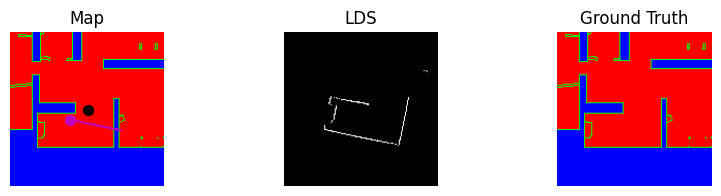

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [ 1.          0.06330593 -0.02529383  0.05288949]


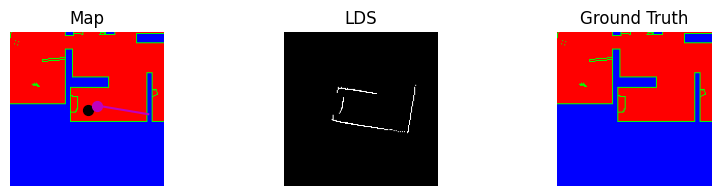

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [1.         0.02421561 0.02895702 0.08700121]


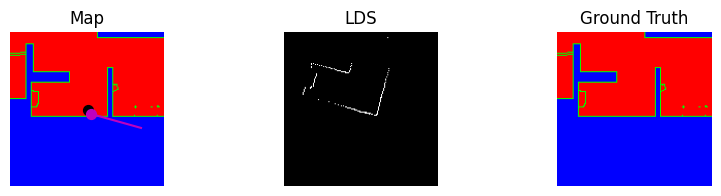

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [ 1.         -0.01872358  0.01375992  0.0639921 ]


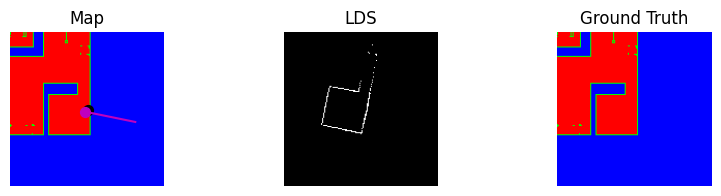

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [ 1.         -0.07817483 -0.02833488  0.07742337]


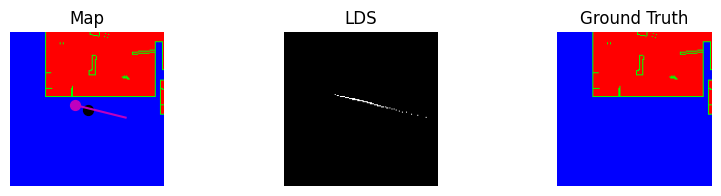

In [9]:
show_dataset(train_data, 5)

## Model output helper functions

In [35]:
model.inputs

[<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=None, name=map_input>,
 <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=None, name=lds_input>]

In [36]:
model.outputs

[<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_222>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_227>]

In [10]:
def display_history(model_history):
  # identify "losses" vs other metrics
  loss_keys = [k for k in model_history.history.keys() if 'loss' in k or 'entropy' in k]
  metric_keys = [k for k in model_history.history.keys() if 'loss' not in k and 'entropy' not in k]

  plt.figure(figsize=(11,3))
  if len(loss_keys) > 0:
    plt.subplot(1,2,1)
    plt.title("Loss")
    for key in loss_keys:
      plt.plot(model_history.epoch, model_history.history[key], label=key)
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')

  if len(metric_keys) > 0:
    plt.subplot(1,2,2)
    plt.title("Metrics")
    for key in metric_keys:
      plt.plot(model_history.epoch, model_history.history[key], label=key)
    plt.legend()
    plt.xlabel('Epoch')

  plt.show()

In [11]:
def show_prediction(map_window, lds_map, ground_truth_map, adlo, map_pred, adlo_pred):
  # apply scaling
  map_pred_scaled = tf.nn.softmax(map_pred, axis=-1)
  map_pred_categorical = tf.argmax(map_pred, axis=-1)

  accept = tf.nn.sigmoid(adlo_pred[0])
  delta_x = tf.nn.tanh(adlo_pred[1]) * 0.5
  delta_y = tf.nn.tanh(adlo_pred[2]) * 0.5
  delta_angle = tf.nn.tanh(adlo_pred[3])
  adlo_pred_scaled = tf.stack([accept, delta_x, delta_y, delta_angle], axis=0)

  range = np.array([map_window.shape[1], map_window.shape[0]])
  centre = range / 2
  error_loc = centre + adlo[1:3]*range
  angle_loc = error_loc + np.array([np.cos(adlo[3]*np.pi), np.sin(adlo[3]*np.pi)])*50

  print(f"adlo:             {adlo}")
  print(f"adlo-predicted:   {adlo_pred_scaled}")

  plt.figure(figsize=(10,2))
  plt.subplot(1, 5, 1)
  plt.title('Map')
  plt.imshow(map_window)
  plt.axis('off')
  plt.plot([error_loc[0], angle_loc[0]], [error_loc[1], angle_loc[1]], c='m')
  plt.scatter(centre[0], centre[1], c='k', s=50)
  plt.scatter(error_loc[0], error_loc[1], c='m', s=50)

  plt.subplot(1, 5, 2)
  plt.title('LDS')
  plt.imshow(lds_map, cmap='gray')
  plt.axis('off')

  plt.subplot(1, 5, 3)
  plt.title('Ground Truth')
  plt.imshow(ground_truth_map)
  plt.axis('off')

  plt.subplot(1, 5, 4)
  plt.title('Predicted')
  plt.imshow(map_pred_categorical)
  plt.axis('off')

  plt.subplot(1, 5, 5)
  plt.title('Pred Raw')
  plt.imshow(map_pred_scaled)
  plt.axis('off')
  plt.show()

def show_predictions(model, dataset, num=1, show_probs=True):
  for (map_window, lds_map), (ground_truth_map, adlo) in train_data.take(num):
    map_input = tf.expand_dims(map_window, axis=0)
    lds_input = tf.expand_dims(lds_map, axis=0)
    batch = [map_input, lds_input]

    batch_pred = model.predict(batch)

    map_pred = batch_pred[0][0]
    adlo_pred = batch_pred[1][0]
    show_prediction(map_window, lds_map, ground_truth_map, adlo, map_pred, adlo_pred)

show_predictions(model, train_data)

NameError: name 'model' is not defined

## Model training

In [27]:
one = next(iter(train_data))
print(f"one: {type(one)} with {len(one)} x {type(one[0])}")
print(f"one[0]: {type(one[0])} with {len(one[0])} of {type(one[0][0])}")
print(f"one[0][0]: {one[0][0].shape}")
print(f"one[0][1]: {one[0][1].shape}")
print(f"one[0]: {type(one[1])} with {len(one[1])} of {type(one[1][0])}")
print(f"one[1][0]: {one[1][0].shape}")
print(f"one[1][1]: {one[1][1].shape}")

one: <class 'tuple'> with 2 x <class 'tuple'>
one[0]: <class 'tuple'> with 2 of <class 'tensorflow.python.framework.ops.EagerTensor'>
one[0][0]: (149, 149, 3)
one[0][1]: (149, 149)
one[0]: <class 'tuple'> with 2 of <class 'tensorflow.python.framework.ops.EagerTensor'>
one[1][0]: (149, 149, 3)
one[1][1]: (4,)


In [13]:
reload(slam)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

map_shape: (149, 149, 3)
Map shape: (149, 149, 3) + padding (11, 11, 0)
Skip-connection merge mode: concat
Output: logits
Added final cropping layer: w=11, h=11


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ map_input (InputLayer)    │ (None, 149, 149, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 160, 160, 3)    │              0 │ map_input[0][0]        │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 160, 160, 32)   │            896 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 160, 160, 32)   │          9,248 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 80, 80, 32)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 80, 80, 64)     │         36,928 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 40, 40, 64)     │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 40, 40, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 40, 40, 128)    │        147,584 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 20, 20, 128)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 20, 20, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 20, 20, 256)    │        590,080 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 20, 20, 256)    │              0 │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 10, 10, 256)    │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 10, 10, 512)    │      1,180,160 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 10, 10, 512)    │      2,359,808 │ conv2d_29[0][0]        │
├──────────────────────

 Total params: 9,190,231 (35.06 MB)

 Trainable params: 9,190,231 (35.06 MB)

 Non-trainable params: 0 (0.00 B)

map_shape: (149, 149, 3)
Map shape: (149, 149, 3) + padding (11, 11, 0)
Skip-connection merge mode: concat
Output: logits
Added final cropping layer: w=11, h=11
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - adlo_output_accuracy: 0.3351 - adlo_output_adlo_loss: 0.2058 - loss: 0.4785 - map_output_accuracy: 0.9170 - map_output_map_loss: 0.2725
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - adlo_output_accuracy: 1.0000 - adlo_output_adlo_loss: 0.0027 - loss: 0.0113 - map_output_accuracy: 0.9973 - map_output_map_loss: 0.0086
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 413ms/step - adlo_output_accuracy: 1.0000 - adlo_output_adlo_loss: 0.0017 - loss: 0.0031 - map_output_accuracy: 0.9995 - map_output_map_loss: 0.0014
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 408ms/step - adlo_output_accuracy: 1.0000 - adlo_output_adlo_loss: 0.0017 - loss: 0.0019 - map_output_accuracy: 1.0000 - map_output_map_loss: 2.3551e-04
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - adlo_output_accuracy: 1.

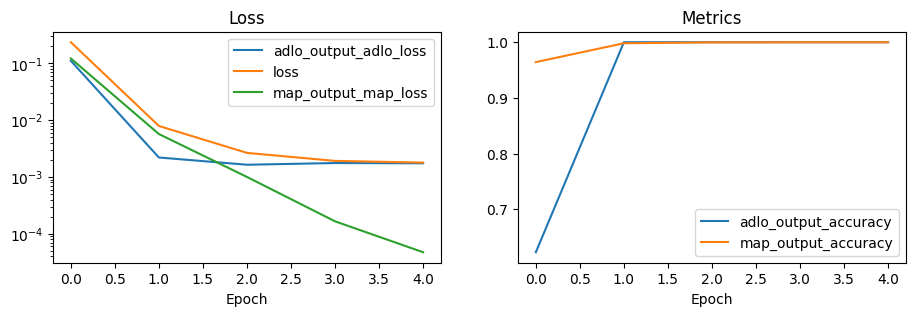

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
adlo:             [ 1.         -0.11341641  0.06667727  0.06458941]
adlo-predicted:   [ 0.95642644  0.01675647 -0.02487805  0.04101649]


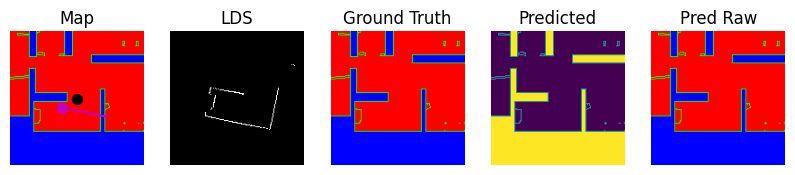

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
adlo:             [ 1.          0.06330593 -0.02529383  0.05288949]
adlo-predicted:   [ 0.952434    0.01741333 -0.0231371   0.04091474]


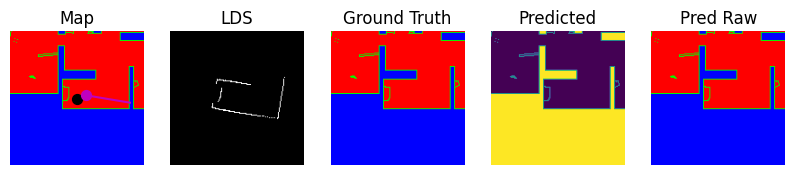

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
adlo:             [1.         0.02421561 0.02895702 0.08700121]
adlo-predicted:   [ 0.9551767   0.01757911 -0.02433445  0.04202544]


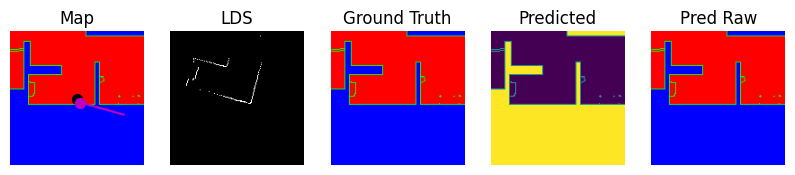

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
adlo:             [ 1.         -0.01872358  0.01375992  0.0639921 ]
adlo-predicted:   [ 0.95274794  0.01759746 -0.0227649   0.0399205 ]


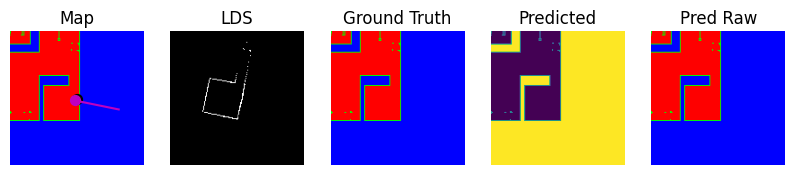

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
adlo:             [ 1.         -0.07817483 -0.02833488  0.07742337]
adlo-predicted:   [ 0.950548    0.01713423 -0.02190825  0.04096223]


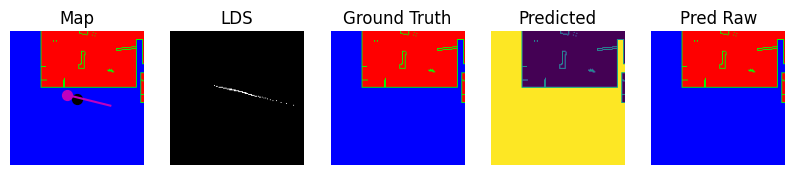

In [12]:
# Custom loss functions
# (out-of-the-box the two outputs get losses calculated independently,
#  ultimately I'll be wanting to conditionally choose whether the map loss
#  is considered depending on how the network is being used.
#  The easiest way to do that will be to generate the dataset so that the ground_truth_map
#  is blank for those cases)

def adlo_loss(y_true, y_pred):
    """
    y_true: (B,4), scaled
    y_pred: (B,4), logits
    """
    # scale logits to correct ranges
    accept = tf.nn.sigmoid(y_pred[:, 0])
    delta_x = tf.nn.tanh(y_pred[:, 1]) * 0.5
    delta_y = tf.nn.tanh(y_pred[:, 2]) * 0.5
    delta_angle = tf.nn.tanh(y_pred[:, 3])
    y_pred_scaled = tf.stack([accept, delta_x, delta_y, delta_angle], axis=1)

    # apply simple MSE across the lot
    # (TODO be a little smarter)
    losses = tf.keras.losses.MSE(y_true, y_pred_scaled)
    return tf.reduce_mean(losses)

reload(slam)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")

# train on just the map
model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              loss={
                  'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'adlo_output': adlo_loss
              },
              metrics={
                  'map_output': [tf.keras.metrics.CategoricalCrossentropy(from_logits=True, name='map_loss'), 'accuracy'],
                  'adlo_output': [adlo_loss, 'accuracy']
              })

#model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
#model.compile(optimizer='adam',
#              loss={
#                  'map_output': 'categorical_crossentropy',
#                  'adlo_output': adlo_loss
#              },
#              metrics={
#                  'map_output': ['categorical_crossentropy', 'accuracy'],
#                  'adlo_output': [adlo_loss, 'accuracy']
#              })

epochs = 5
batch_size = 32
model_train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
show_predictions(model, train_data, 5)

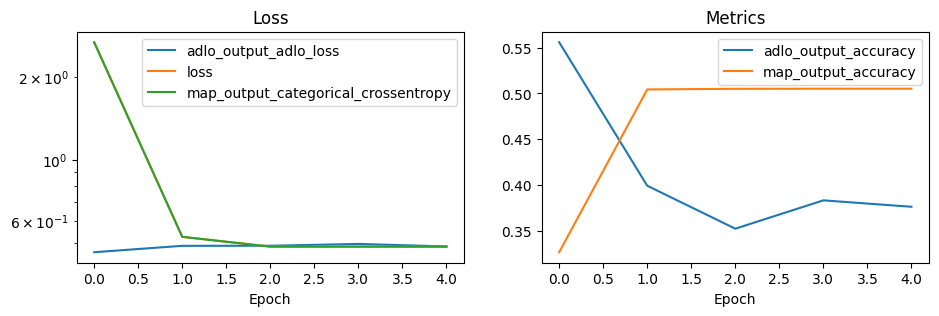

In [99]:
display_history(model_history)

## Much simpler model


map_shape: (149, 149, 3)
Map shape: (149, 149, 3) + padding (11, 11, 0)
Skip-connection merge mode: concat
Output: logits
Added final cropping layer: w=11, h=11
Model summary:
  Inputs:     [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=None, name=lds_input>]
  Outputs:    [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_535>]
  Parameters: 10991139
Rebuilding simple_train_data
Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 603ms/step - accuracy: 0.8517 - loss: 0.6776
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 366ms/step - accuracy: 0.9967 - loss: 0.0127
Epochs: 2, duration: 62.49558357500064 sec


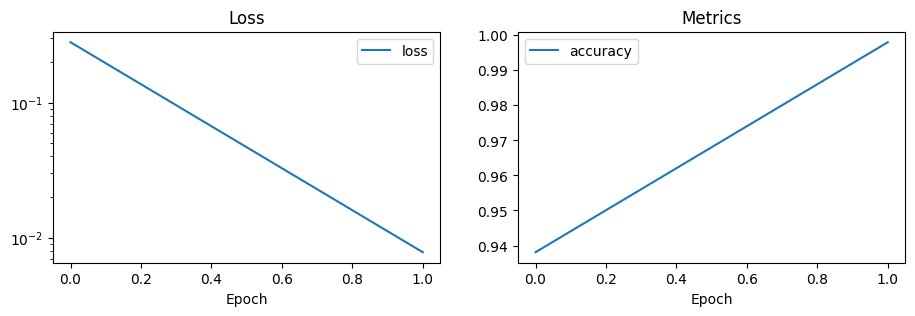

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [48]:
def simple_show_prediction(map_window, lds_map, ground_truth_map, adlo, map_pred, adlo_pred):
  # apply scaling
  map_pred_scaled = tf.nn.softmax(map_pred, axis=-1)
  map_pred_categorical = tf.argmax(map_pred, axis=-1)

  if adlo_pred is not None:
    accept = tf.nn.sigmoid(adlo_pred[0])
    delta_x = tf.nn.tanh(adlo_pred[1]) * 0.5
    delta_y = tf.nn.tanh(adlo_pred[2]) * 0.5
    delta_angle = tf.nn.tanh(adlo_pred[3])
    adlo_pred_scaled = tf.stack([accept, delta_x, delta_y, delta_angle], axis=0)
  else:
    adlo_pred_scaled = None

  range = np.array([map_window.shape[1], map_window.shape[0]])
  centre = range / 2
  if adlo is not None:
    error_loc = centre + adlo[1:3]*range
    angle_loc = error_loc + np.array([np.cos(adlo[3]*np.pi), np.sin(adlo[3]*np.pi)])*50
  else:
    error_loc = None
    angle_loc = None

  print(f"adlo:             {adlo}")
  print(f"adlo-predicted:   {adlo_pred_scaled}")

  if map_window is not None:
    plt.figure(figsize=(10,2))
    plt.subplot(1, 5, 1)
    plt.title('Map')
    plt.imshow(map_window)
    plt.axis('off')
    plt.scatter(centre[0], centre[1], c='k', s=50)
    if error_loc is not None:
      plt.plot([error_loc[0], angle_loc[0]], [error_loc[1], angle_loc[1]], c='m')
      plt.scatter(error_loc[0], error_loc[1], c='m', s=50)

  if lds_map is not None:
    plt.subplot(1, 5, 2)
    plt.title('LDS')
    plt.imshow(lds_map, cmap='gray')
    plt.axis('off')

  if ground_truth_map is not None:
    plt.subplot(1, 5, 3)
    plt.title('Ground Truth')
    plt.imshow(ground_truth_map)
    plt.axis('off')

  if map_pred_categorical is not None:
    plt.subplot(1, 5, 4)
    plt.title('Predicted')
    plt.imshow(map_pred_categorical)
    plt.axis('off')

  if map_pred_scaled is not None:
    plt.subplot(1, 5, 5)
    plt.title('Pred Raw')
    plt.imshow(map_pred_scaled)
    plt.axis('off')
    plt.show()

def simple_show_predictions(model, dataset, num=1, show_probs=True):
  batch = next(iter(dataset.batch(num)))
  preds = model.predict(batch[0])
  print(f"batch:    {type(batch)} x {len(batch)}, {np.shape(batch)}")
  print(f"batch[0]: {type(batch[0])} x {len(batch[0])}, {np.shape(batch[0])}")
  print(f"preds:    {type(preds)} x {len(preds)}, {np.shape(preds)}")

  for inputs, outputs, preds in zip(batch[0], batch[1], preds):
    #show_prediction(inputs, outputs)
    map_input = None
    lds_input = None
    ground_truth_map = None
    adlo = None
    map_pred = None
    adlo_pred = None

    #print(f"inputs:  {type(inputs)} x {len(inputs)}, {np.shape(inputs)}")
    #print(f"outputs: {type(outputs)} x {len(outputs)}, {np.shape(outputs)}")
    #print(f"preds:   {type(preds)} x {len(preds)}, {np.shape(preds)}")

    if isinstance(inputs, tuple):
      map_input = inputs[0]
      lds_input = inputs[1] if len(inputs) >= 2 else None
    else:
      map_input = inputs

    if isinstance(outputs, tuple):
      ground_truth_map = outputs[0]
      adlo = outputs[1] if len(outputs) >= 2 else None
    else:
      ground_truth_map = outputs

    if isinstance(preds, tuple):
      map_pred = preds[0]
      adlo_pred = preds[1] if len(preds) >= 2 else None
    else:
      map_pred = preds

    #print(f"map_input: {np.shape(map_input)}")
    #print(f"lds_input: {np.shape(lds_input)}")
    #print(f"ground_truth_map: {np.shape(ground_truth_map)}")
    #print(f"adlo: {np.shape(adlo)}")
    #print(f"map_pred: {np.shape(map_pred)}")
    #print(f"adlo_pred: {np.shape(adlo_pred)}")

    simple_show_prediction(map_input, lds_input, ground_truth_map, adlo, map_pred, adlo_pred)

def simple_model(map_shape, conv_filters, adlo_units, **kwargs):
    """
    Constructs a basic UNet model.

    Has 4 2x2 downsampling blocks on both input arms, matched up with 4 2x2 upsampling blocks.
    Automatically adds padding layers to ensure that the input has dimensions
    that are multiples of 2**4 = 16.

    Args:
      map_shape: tuple of int, (height, width, channels)
        Size and shape of window used for input and output map representation.
        Implies LDS inputs have shape (batch, height, width).
      conv_filters: int
        Base number of filters for the top-most convolutional layers.
        Deeper layers have powers-of-2 multiplies of this number.
      adlo_units: int
        Number of units at each fully-connected layer within ADLO block (Accept, delta Location/Orientation)

    Keyword args:
      merge_mode: str, default: 'concat'
        One of: 'concat' or 'add'.
        How skip connection should be combined with up-scaled input.
      output_logits: bool, default: True
        Whether to output logits, or softmax otherwise.

    Returns:
      model -- tf.keras.Model
    """

    merge_mode = kwargs.get('merge_mode', 'concat')
    output_logits = kwargs.get('output_logits', True)

    # Sanity check
    if np.size(map_shape) != 3:
      raise ValueError("Map shape must have 3 dims, found {np.size(map_shape)}")

    # Prepare map input
    # (pad so it's a multiple of our down/up-scaling blocks)
    map_input = Input(shape=map_shape, name='map_input')
    map_down, pad_w, pad_h = slam.pad_block(map_input, map_shape)
    n_classes = map_shape[2]
    print(f"Map shape: {map_shape} + padding ({pad_h}, {pad_w}, 0)")

    # Prepare LDS input
    # (convert from (B,H,W) to (B,H,W,1) to make later work easier)
    # (pad so it's a multiple of our down/up-scaling blocks)
    lds_shape = (map_shape[0], map_shape[1], 1)
    lds_input = Input(shape=(map_shape[0], map_shape[1]), name='lds_input')  # raw input omits channels axis
    lds_down = tf.keras.layers.Reshape(target_shape=lds_shape)(lds_input)
    lds_down, _, _ = slam.pad_block(lds_down, lds_shape)

    print(f"Skip-connection merge mode: {merge_mode}")
    print("Output: " + ("logits" if output_logits else "scaled"))

    # Map downsampling input arm
    # (each block here returns two outputs (downsampled, convolved-only),
    #  the latter is used for skip-connections)
    map_down, map_skip1 = slam.slam_down_block(map_down, conv_filters)
    map_down, map_skip2 = slam.slam_down_block(map_down, conv_filters * 2)
    map_down, map_skip3 = slam.slam_down_block(map_down, conv_filters * 4)
    map_down, map_skip4 = slam.slam_down_block(map_down, conv_filters * 8, dropout_prob=0.3)

    # LDS downsampling input arm
    lds_down, lds_skip1 = slam.slam_down_block(lds_down, conv_filters)
    lds_down, lds_skip2 = slam.slam_down_block(lds_down, conv_filters * 2)
    lds_down, lds_skip3 = slam.slam_down_block(lds_down, conv_filters * 4)
    lds_down, lds_skip4 = slam.slam_down_block(lds_down, conv_filters * 8, dropout_prob=0.3)

    # Bottom layer (no scale changes)
    bottom = Concatenate(axis=3)([map_down, lds_down])
    bottom, _ = slam.slam_down_block(bottom, conv_filters * 16, dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)
    # (feed in skip-connections
    ublock6 = unet.unet_upsampling_block(bottom, map_skip4, conv_filters*8, merge_mode=merge_mode)
    ublock7 = unet.unet_upsampling_block(ublock6, map_skip3, conv_filters*4, merge_mode=merge_mode)
    ublock8 = unet.unet_upsampling_block(ublock7, map_skip2, conv_filters*2, merge_mode=merge_mode)
    ublock9 = unet.unet_upsampling_block(ublock8, map_skip1, conv_filters, merge_mode=merge_mode)

    #ublock9 = padded_input

    # Final map output
    # (one last convolve, collapse channels down to desired number of output classes, output either logits or softmax,
    #  and remove padding)
    conv10 = Conv2D(conv_filters,
                     kernel_size=(3, 3),
                     activation='relu',
                     padding='same',
                     kernel_initializer='he_normal')(ublock9)
    conv11 = Conv2D(filters=n_classes,
                     kernel_size=(1, 1),
                     padding='same',
                     activation=None)(conv10)
    print(f"Added final cropping layer: w={pad_w}, h={pad_h}")
    map_out = Cropping2D(cropping=((pad_h//2, pad_h-pad_h//2), (pad_w//2, pad_w-pad_w//2)),
                          name='map_output')(conv11)

    model = tf.keras.Model(inputs=[map_input, lds_input], outputs=map_out)
    return model

def build_simple_dataset(full_dataset):
  input_maps = []
  lds_maps = []
  ground_truth_maps = []
  for (map_window, lds_map), (ground_truth_map, adlo) in full_dataset:
    input_maps.append(map_window)
    lds_maps.append(lds_map)
    ground_truth_maps.append(ground_truth_map)
  return tf.data.Dataset.from_tensor_slices((
      (np.array(input_maps), np.array(lds_maps)),
      np.array(ground_truth_maps)
  ))


reload(unet)
reload(slam)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

# train on just the map
model = simple_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )
print("Model summary:")
print(f"  Inputs:     {model.inputs}")
print(f"  Outputs:    {model.outputs}")
print(f"  Parameters: {model.count_params()}")

epochs = 2
batch_size = 32
try:
  #raise NameError("")
  if simple_train_data is None:
    raise NameError("")
  print(f"Re-using simple_train_data: {len(simple_train_data)}")
except NameError:
  print(f"Rebuilding simple_train_data")
  simple_train_data = build_simple_dataset(train_data)
#model_train_data = simple_train_data.shuffle(buffer_size=len(simple_train_data)).batch(batch_size)
model_train_data = simple_train_data.batch(batch_size)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
simple_show_predictions(model, simple_train_data, 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
batch:    <class 'tuple'> x 2 x (<class 'tuple'>,...)
batch[0]: <class 'tuple'> x 2
batch[0][0]: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape (4, 149, 149, 3)
batch[0][1]: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape (4, 149, 149)
batch[1]: <class 'tensorflow.python.framework.ops.EagerTensor'> x 4, shape (4, 149, 149, 3)
preds:    <class 'numpy.ndarray'> x 4, (4, 149, 149, 3)
map_input: (149, 149, 3)
lds_input: (149, 149)
ground_truth_map: (149, 149, 3)
adlo: ()
map_pred: (149, 149, 3)
adlo_pred: ()
adlo:             None
adlo-predicted:   None


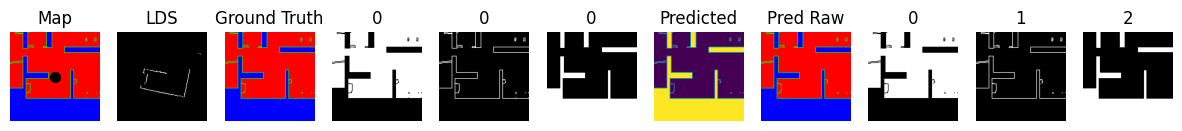

map_input: (149, 149, 3)
lds_input: (149, 149)
ground_truth_map: (149, 149, 3)
adlo: ()
map_pred: (149, 149, 3)
adlo_pred: ()
adlo:             None
adlo-predicted:   None


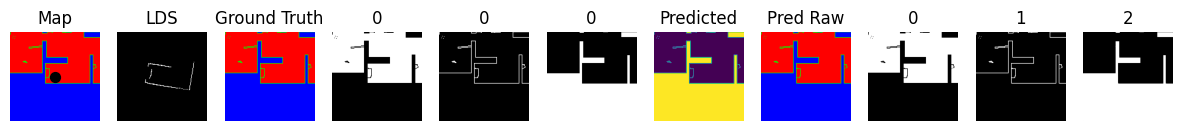

map_input: (149, 149, 3)
lds_input: (149, 149)
ground_truth_map: (149, 149, 3)
adlo: ()
map_pred: (149, 149, 3)
adlo_pred: ()
adlo:             None
adlo-predicted:   None


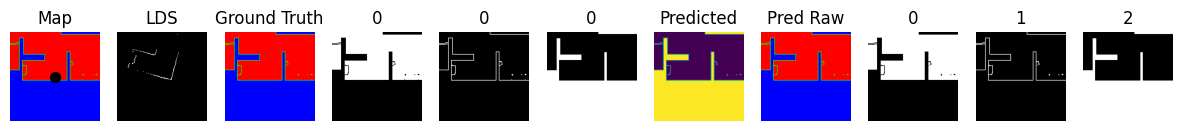

map_input: (149, 149, 3)
lds_input: (149, 149)
ground_truth_map: (149, 149, 3)
adlo: ()
map_pred: (149, 149, 3)
adlo_pred: ()
adlo:             None
adlo-predicted:   None


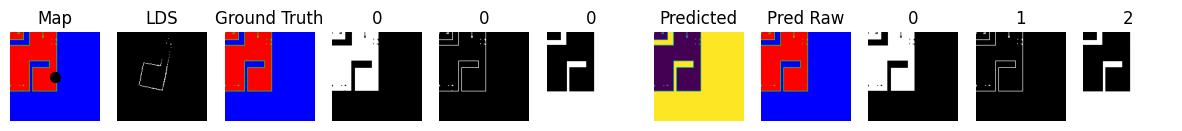

In [71]:
def simple_show_prediction(map_window, lds_map, ground_truth_map, adlo, map_pred, adlo_pred):
  # apply scaling
  map_pred_scaled = tf.nn.softmax(map_pred, axis=-1)
  map_pred_categorical = tf.argmax(map_pred, axis=-1)

  if adlo_pred is not None:
    accept = tf.nn.sigmoid(adlo_pred[0])
    delta_x = tf.nn.tanh(adlo_pred[1]) * 0.5
    delta_y = tf.nn.tanh(adlo_pred[2]) * 0.5
    delta_angle = tf.nn.tanh(adlo_pred[3])
    adlo_pred_scaled = tf.stack([accept, delta_x, delta_y, delta_angle], axis=0)
  else:
    adlo_pred_scaled = None

  range = np.array([map_window.shape[1], map_window.shape[0]])
  centre = range / 2
  if adlo is not None:
    error_loc = centre + adlo[1:3]*range
    angle_loc = error_loc + np.array([np.cos(adlo[3]*np.pi), np.sin(adlo[3]*np.pi)])*50
  else:
    error_loc = None
    angle_loc = None

  print(f"adlo:             {adlo}")
  print(f"adlo-predicted:   {adlo_pred_scaled}")
  plt.figure(figsize=(15,2))

  cols = 11
  if map_window is not None:
    plt.subplot(1, cols, 1)
    plt.title('Map')
    plt.imshow(map_window)
    plt.axis('off')
    plt.scatter(centre[0], centre[1], c='k', s=50)
    if error_loc is not None:
      plt.plot([error_loc[0], angle_loc[0]], [error_loc[1], angle_loc[1]], c='m')
      plt.scatter(error_loc[0], error_loc[1], c='m', s=50)

  if lds_map is not None:
    plt.subplot(1, cols, 2)
    plt.title('LDS')
    plt.imshow(lds_map, cmap='gray')
    plt.axis('off')

  if ground_truth_map is not None:
    plt.subplot(1, cols, 3)
    plt.title('Ground Truth')
    plt.imshow(ground_truth_map)
    plt.axis('off')

    plt.subplot(1, cols, 4)
    plt.title('0')
    plt.imshow(ground_truth_map[..., 0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, cols, 5)
    plt.title('0')
    plt.imshow(ground_truth_map[..., 1], cmap='gray')
    plt.axis('off')

    plt.subplot(1, cols, 6)
    plt.title('0')
    plt.imshow(ground_truth_map[..., 2], cmap='gray')
    plt.axis('off')

  if map_pred_categorical is not None:
    plt.subplot(1, cols, 7)
    plt.title('Predicted')
    plt.imshow(map_pred_categorical)
    plt.axis('off')

  if map_pred_scaled is not None:
    plt.subplot(1, cols, 8)
    plt.title('Pred Raw')
    plt.imshow(map_pred_scaled)
    plt.axis('off')

    plt.subplot(1, cols, 9)
    plt.title('0')
    plt.imshow(map_pred_scaled[...,0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, cols, 10)
    plt.title('1')
    plt.imshow(map_pred_scaled[...,1], cmap='gray')
    plt.axis('off')

    plt.subplot(1, cols, 11)
    plt.title('2')
    plt.imshow(map_pred_scaled[...,2], cmap='gray')
    plt.axis('off')

  plt.show()

def simple_show_predictions(model, dataset, num=1, show_probs=True):
  """
  Batch: tuple: (inputs, outputs)
  inputs: either a single input or a tuple of inputs
  outputs: either a single output or a tuple of outputs
  """
  batch = next(iter(dataset.batch(num)))
  preds = model.predict(batch[0])
  print(f"batch:    {type(batch)} x {len(batch)} x ({type(batch[0])},...)")
  for i in range(len(batch)):
    if isinstance(batch[i], tuple):
      print(f"batch[{i}]: {type(batch[i])} x {len(batch[i])}")
      print(f"batch[{i}][0]: {type(batch[i][0])}, shape {np.shape(batch[i][0])}")
      print(f"batch[{i}][1]: {type(batch[i][1])}, shape {np.shape(batch[i][1])}")
    else:
      print(f"batch[{i}]: {type(batch[i])} x {len(batch[i])}, shape {np.shape(batch[i])}")
  print(f"preds:    {type(preds)} x {len(preds)}, {np.shape(preds)}")

  if isinstance(batch[0], tuple):
    map_inputs = batch[0][0]
    lds_inputs = batch[0][1] if len(batch[0]) >= 2 else None
  else:
    map_inputs = batch[0]
    lds_inputs = [None] * len(map_inputs)

  if isinstance(batch[1], tuple):
    ground_truth_maps = batch[1][0]
    adlos = batch[1][1] if len(batch[1]) >= 2 else None
  else:
    ground_truth_maps = batch[1]
    adlos = [None] * len(ground_truth_maps)

  if isinstance(preds, tuple):
    map_preds = preds[0]
    adlo_preds = preds[1] if len(preds) >= 2 else None
  else:
    map_preds = preds
    adlo_preds = [None] * len(map_preds)

  for map_input, lds_input, ground_truth_map, adlo, map_pred, adlo_pred in zip(map_inputs, lds_inputs, ground_truth_maps, adlos, map_preds, adlo_preds):
    #print(f"inputs:  {type(inputs)} x {len(inputs)}, {np.shape(inputs)}")
    #print(f"outputs: {type(outputs)} x {len(outputs)}, {np.shape(outputs)}")
    #print(f"preds:   {type(preds)} x {len(preds)}, {np.shape(preds)}")

    print(f"map_input: {np.shape(map_input)}")
    print(f"lds_input: {np.shape(lds_input)}")
    print(f"ground_truth_map: {np.shape(ground_truth_map)}")
    print(f"adlo: {np.shape(adlo)}")
    print(f"map_pred: {np.shape(map_pred)}")
    print(f"adlo_pred: {np.shape(adlo_pred)}")
    simple_show_prediction(map_input, lds_input, ground_truth_map, adlo, map_pred, adlo_pred)

simple_show_predictions(model, simple_train_data, num=4)

In [68]:
list(zip(np.array([1, 2, 3]), np.array([4,5,6]), np.array([8,9,10]), None ))

TypeError: 'NoneType' object is not iterable

## Simple experimental model with multiple outputs
To prove out how to set a custom loss fn that works across both outputs

In [89]:
def simple_two_headed_model():
  input = tf.keras.layers.Input(shape=(32,), name="input")

  # Process input
  x = tf.keras.layers.Dense(16, activation='relu')(input)
  x = tf.keras.layers.Dense(8, activation='relu')(x)

  # Define two separate output layers
  output_1 = tf.keras.layers.Dense(10, activation='softmax', name="output_1")(x)  # Classification task
  output_2 = tf.keras.layers.Dense(1, activation='linear', name="output_2")(x)    # Regression task

  # Create the model
  model = tf.keras.Model(inputs=[input], outputs=[output_1, output_2])
  return model

def simple_two_headed_dataset():
  input_data = np.random.rand(1000, 32).astype(np.float32)  # 1000 samples, 32 features

  # Outputs for the model
  output_1_data = np.random.randint(0, 10, size=(1000,)).astype(np.int32)  # 10 classes (for classification)
  output_2_data = np.random.rand(1000, 1).astype(np.float32)  # Regression output

  # Create a tf.data.Dataset from the arrays
  dataset = tf.data.Dataset.from_tensor_slices((
      input_data,  # input data
      (output_1_data, output_2_data)  # Tuple of output data
  ))
  return dataset

model = simple_two_headed_model()
model.summary()

dataset = simple_two_headed_dataset()
len(dataset)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 16)             │            528 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 8)              │            136 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_1 (Dense)          │ (None, 10)             │             90 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_2 (Dense)          │ (None, 1)              │              9 │ dense_23[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 763 (2.98 KB)

 Trainable params: 763 (2.98 KB)

 Non-trainable params: 0 (0.00 B)

1000

In [90]:
model = simple_two_headed_model()
model.compile(
    optimizer='adam',
    loss={
        'output_1': 'sparse_categorical_crossentropy',  # Loss for classification output
        'output_2': 'mse'  # Loss for regression output
    },
    loss_weights={
        'output_1': 0.5,  # Weight for classification loss
        'output_2': 0.5   # Weight for regression loss
    },
    metrics={
        'output_1': 'accuracy',  # Metric for classification output
        'output_2': 'mae'  # Metric for regression output
    }
)
history = model.fit(dataset.batch(32), epochs=5)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3148 - output_1_accuracy: 0.1030 - output_2_mae: 0.4521
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2316 - output_1_accuracy: 0.0917 - output_2_mae: 0.3044 
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2155 - output_1_accuracy: 0.0832 - output_2_mae: 0.2726 
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2100 - output_1_accuracy: 0.0904 - output_2_mae: 0.2655
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2061 - output_1_accuracy: 0.0967 - output_2_mae: 0.2619 


In [93]:
def custom_loss1(y_true, y_pred):
    print(f"loss1 - y_true: {y_true.shape}, y_pred: {y_pred.shape}")
    losses = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return tf.reduce_mean(losses)

def custom_loss2(y_true, y_pred):
    print(f"loss2 - y_true: {y_true.shape}, y_pred: {y_pred.shape}")
    losses = tf.keras.losses.MSE(y_true, y_pred)
    return tf.reduce_mean(losses)

model = simple_two_headed_model()
model.compile(
    optimizer='adam',
    loss={
        'output_1': custom_loss1,
        'output_2': custom_loss2
    },
    loss_weights={
        'output_1': 0.5,  # Weight for classification loss
        'output_2': 0.5   # Weight for regression loss
    },
    metrics={
        'output_1': 'accuracy',  # Metric for classification output
        'output_2': 'mae'  # Metric for regression output
    }
)
history = model.fit(dataset.batch(32), epochs=5)

Epoch 1/5
loss1 - y_true: (None,), y_pred: (None, 10)
loss2 - y_true: (None, 1), y_pred: (None, 1)
loss1 - y_true: (None,), y_pred: (None, 10)
loss2 - y_true: (None, 1), y_pred: (None, 1)
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2887 - output_1_accuracy: 0.1064 - output_2_mae: 0.3644
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2200 - output_1_accuracy: 0.1301 - output_2_mae: 0.2896
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2098 - output_1_accuracy: 0.1264 - output_2_mae: 0.2730 
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2058 - output_1_accuracy: 0.1230 - output_2_mae: 0.2682
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2028 - output_1_accuracy: 0.1108 - output_2_mae: 0.2652     


In [97]:
def custom_loss1(y_true, y_pred):
    print(f"loss1 - y_true: {y_true.shape}, y_pred: {y_pred.shape}")
    losses = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return tf.reduce_mean(losses)

def custom_loss2(y_true, y_pred):
    print(f"loss2 - y_true: {y_true.shape}, y_pred: {y_pred.shape}")
    losses = tf.keras.losses.MSE(y_true, y_pred)
    return tf.reduce_mean(losses)

model = simple_two_headed_model()
model.compile(
    optimizer='adam',
    loss=[custom_loss1, custom_loss2],
    metrics=['accuracy','mae']
)
history = model.fit(dataset.batch(32), epochs=5)

Epoch 1/5
loss1 - y_true: (None,), y_pred: (None, 10)
loss2 - y_true: (None, 1), y_pred: (None, 1)
loss1 - y_true: (None,), y_pred: (None, 10)
loss2 - y_true: (None, 1), y_pred: (None, 1)
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 3.2131 - output_1_accuracy: 0.1272 - output_2_mae: 0.8431 
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4709 - output_1_accuracy: 0.1138 - output_2_mae: 0.3265
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4356 - output_1_accuracy: 0.1198 - output_2_mae: 0.3028
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4241 - output_1_accuracy: 0.1202 - output_2_mae: 0.2925 
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4150 - output_1_accuracy: 0.1248 - output_2_mae: 0.2847


In [95]:
def custom_loss_both(y_true, y_pred):
    print(f"loss_both - y_true: {y_true.shape}, y_pred: {y_pred.shape}")
    losses = tf.keras.losses.MSE(y_true, y_pred)
    return tf.reduce_mean(losses)

model = simple_two_headed_model()
model.compile(
    optimizer='adam',
    loss=custom_loss_both,
    metrics={
        'output_1': 'accuracy',  # Metric for classification output
        'output_2': 'mae'  # Metric for regression output
    }
)
history = model.fit(dataset.batch(32), epochs=5)

Epoch 1/5
loss_both - y_true: (None,), y_pred: (None, 10)
loss_both - y_true: (None, 1), y_pred: (None, 1)
loss_both - y_true: (None,), y_pred: (None, 10)
loss_both - y_true: (None, 1), y_pred: (None, 1)


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/custom_loss_both/sub/BroadcastGradientArgs defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-95-ef8dd68d70ed>", line 15, in <cell line: 15>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 70, in train_step

Incompatible shapes: [32] vs. [32,10]
	 [[{{node gradient_tape/compile_loss/custom_loss_both/sub/BroadcastGradientArgs}}]] [Op:__inference_one_step_on_iterator_210372]